In [1]:
import os,sys,time,math
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, SparsePCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from scipy import signal
import pyjags

In [2]:
def detrend(data):
    '''
    Regress out the deterministic mean and linear trend by ROI-wise regression.
    
    >>> INPUT
    
    - data: 3d numpy array, nsub x ntime x nroi.
    
    >>> OUTPUT
    
    - data: 3d numpy array, nsub x ntime x nroi.
    '''
    nsub, ntime, nroi = data.shape
    X = np.arange(1,ntime+1)[:,np.newaxis]
    X[:,0] = X[:,0] - np.mean(X[:,0])
    for s in range(nsub):
        for r in range(nroi):
            Y = data[s,:,r]
            model = LinearRegression(fit_intercept=True,
                                     normalize=False).fit(X,Y)
            data[s,:,r] = Y - model.predict(X)
    
    return data

In [3]:
def find_integration_order(data, pval_bound=0.05):
    if type(data)==np.ndarray:
        data = data.tolist()
        for s in range(len(data)):
            data[s] = np.asarray(data[s])
    
    assert(type(data)==list)
    nsub = len(data)
    ords = []
    for s in range(nsub):
        if len(data[s].shape)<2:
            data[s] = data[s][:,np.newaxis]
        
        ntime = data[s].shape[0]
        nroi = data[s].shape[1]
        tmp = np.zeros((nroi))
        for r in range(nroi):
            pval = 1
            ndiff = -1
            while pval >= pval_bound:
                ndiff = ndiff + 1
                pval = adfuller(np.diff(data[s][:,r], n=ndiff))[1]
                # adfuller
                # null hypothesis: there is a unit root (pval(0.3) >= pval_bound(0.05))
                # alternative: there is no unit root (pval(0.001) < pval_bound(0.05))

            tmp[r] = ndiff
        
        ords.append(tmp)
    
    return ords

In [4]:
def pca_everything(data, algorithm='PCA', n_components=5):
    if algorithm == "PCA":
        decomp = PCA(n_components=n_components, 
                     svd_solver = 'full', whiten=False)
    elif algorithm == "SparsePCA":
        decomp = SparsePCA(n_components=n_components, 
                           normalize_components=True)
    elif algorithm == "LatentFactor":
        decomp = FactorAnalysis(n_components=n_components)
    
    nsub = data.shape[0]
    f = []; U = []; epsilon = []
    
    for s in range(nsub):
        Y = data[s,:,:].squeeze() # ntime x nroi
        est = decomp.fit(Y); 
        
        U.append(est.components_.T) # nroi x nfactor
        
        if algorithm == "PCA":
            f.append(Y @ U[s]) # f_all: ntime x nfactor
        elif algorithm == "SparsePCA":
            f.append(est.transform(Y))
        elif algorithm == "LatentFactor":
            f.append(est.transform(Y))
        
        epsilon.append(Y - f[s] @ U[s].T)

    return f, U, epsilon

In [5]:
def sliding_window(ts_data, width=15, stepsize=1):
    '''
    Returns a sliding window (of width n) over data from the iterable.
    s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...


    >>> INPUT

    - ts_data: numpy 2darray, nroi x ntime.
    - wlen: int
    - shift: int

    >>> OUTPUT

    - win_data: list of numpy 2darray (nroi x width)

    '''
    assert(width>0)
    nroi = ts_data.shape[0]
    npad = math.floor(width/2)

    pad_data = np.hstack((np.zeros((nroi,npad)),
                          ts_data,np.zeros((nroi,npad))))
    nt = pad_data.shape[1]

    start = np.arange(0, nt-width+1, stepsize)
    nwin = start.shape[0]

    win_data = []
    for nw in range(nwin):
        win_data.append(pad_data[:,start[nw]:start[nw]+width])

    return win_data


def calc_conn(win_data):
    '''
    Calculate connectivity.


    >>> REQUIRED INPUT

    - data: numpy 2darray, nroi x ntime


    >>> OPTIONAL INPUT

    - method
    - binary
    - ztransformed
    - diagval

    >>> OUTPUT

    - conn: numpy 2darray, nroi x nroi

    '''
    conn = []
    for data in win_data:
        conn.append(np.cov(data)[:,:,np.newaxis])
    
    conn = np.concatenate(conn, axis=2)
    
    return conn

## Preprocessing

In [6]:
# Read data
wd = '/Users/meini/data/DFCmethods/Data sets/SET data'
data = np.loadtxt(wd+'/SET_ROIs_N26_T215.txt')
ntime = 215
nsub = int(data.shape[0]/ntime)
nroi = data.shape[1]
data = np.reshape(data, (nsub, ntime, nroi))
data = detrend(data)

(array([-200, -199, -198, -197, -196, -195, -194, -193, -192, -191, -190,
        -189, -188, -187, -186, -185, -184, -183, -182, -181, -180, -179,
        -178, -177, -176, -175, -174, -173, -172, -171, -170, -169, -168,
        -167, -166, -165, -164, -163, -162, -161, -160, -159, -158, -157,
        -156, -155, -154, -153, -152, -151, -150, -149, -148, -147, -146,
        -145, -144, -143, -142, -141, -140, -139, -138, -137, -136, -135,
        -134, -133, -132, -131, -130, -129, -128, -127, -126, -125, -124,
        -123, -122, -121, -120, -119, -118, -117, -116, -115, -114, -113,
        -112, -111, -110, -109, -108, -107, -106, -105, -104, -103, -102,
        -101, -100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,
         -90,  -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,
         -79,  -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,
         -68,  -67,  -66,  -65,  -64,  -63,  -62,  -61,  -60,  -59,  -58,
         -57,  -56,  -55,  -54,  -53, 

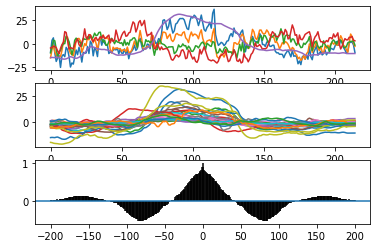

In [7]:
fig, ax = plt.subplots(3,1)
for r in range(nroi):
    ax[0].plot(data[0,:,r])

for s in range(nsub):
    ax[1].plot(data[s,:,4])

ax[2].acorr(data[0,:,0], maxlags=200)

Hemodynamic response is removed. Then we just need to regress out the linear trend or even quadratic $(1,t,t^2)$ estimated by least square.

In [7]:
# Split into rest and task
stimuli = np.hstack([np.tile('rest',60), 
                     np.tile('task',77), 
                     np.tile('rest',78)])
data_rest = data[:,stimuli=='rest',:]
data_task = data[:,stimuli=='task',:]

## Analysis in the ROI Level

In [16]:
# Test for the existence of unit roots
def find_integration_order(data, pval_bound=0.05):
    if type(data)==np.ndarray:
        data = data.tolist()
        for s in range(len(data)):
            data[s] = np.asarray(data[s])
    
    assert(type(data)==list)
    nsub = len(data)
    ords = []
    for s in range(nsub):
        ntime = data[s].shape[0]
        nroi = data[s].shape[1]
        tmp = np.zeros((nroi))
        for r in range(nroi):
            pval = 1
            ndiff = -1
            while pval >= pval_bound:
                ndiff = ndiff + 1
                pval = adfuller(np.diff(data[s][:,r], n=ndiff))[1]

            tmp[r] = ndiff
        
        ords.append(tmp)
    
    return ords

In [17]:
ords = np.asarray(find_integration_order(data))
print(ords)

[[1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 1.]
 [1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1.]
 [1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 1.]
 [1. 0. 0. 1. 1.]
 [1. 1. 0. 0. 1.]
 [1. 1. 0. 0. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 2.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 2.]
 [0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0.]]


## Analysis in the Factor Level

$$
\begin{aligned}
& Y_t = Uf_t \Rightarrow f_t = U'Y_t.
& Y = FU' \Rightarrow F = YU
\end{aligned}
$$

In [14]:
f_all, U_all, epsilon_all = pca_everything(data, n_components=4)

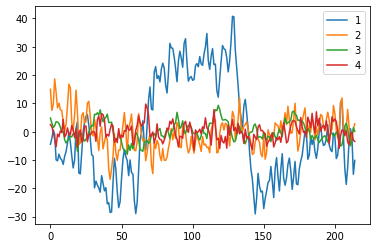

In [15]:
plt.figure()
for r in range(f_all[2].shape[1]):
    plt.plot(f_all[2][:,r])

plt.legend([r+1 for r in range(f_all[2].shape[1])])

It shows that there are some factors are nonstationary (factor 1, 3 and 4) and cointegrated (factor 2 and factor 3), which can be further confirmed using the following tests.

In [16]:
# The integration orders are printed.
ords = np.asarray(find_integration_order(f_all))
ords

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 1., 0., 1.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [0., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [17]:
# Take a look at the cointegrations
pval_bound = 0.05
coords = np.zeros((len(f_all), 6))
for s in range(len(f_all)):
    i = 0
    for combs in it.combinations(f_all[s].T,2):
        coords[s,i] = coint(combs[0], combs[1])[1] < pval_bound
        i = i+1

coords
# The cointegration relationships are printed.

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0., 1.],
       [1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 1., 0.],
       [1., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 1., 1.]])

But note that this estimation of dynamic factors are not reliable because neither the original time series nor the factor time series is stationary.

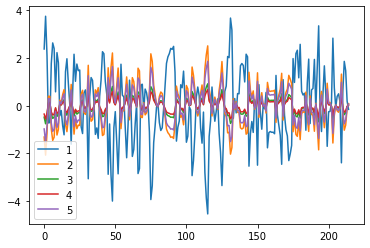

In [18]:
plt.figure()
for r in range(epsilon_all[2].shape[1]):
    plt.plot(epsilon_all[2][:,r])

plt.legend([r+1 for r in range(epsilon_all[2].shape[1])])

In [19]:
ords = np.asarray(find_integration_order(epsilon_all))
ords

array([[1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.]])

The error terms are all integrated of order 1. This makes it suitable to use the I(1) dynamic factor model.

[[0. 0. 0. 0.]]


Text(0.5, 0.98, 'Logarithm of factor volatilities: Subject 1.')

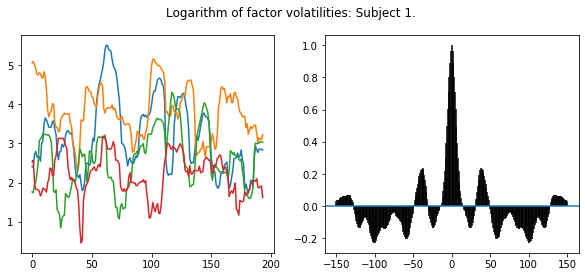

In [30]:
win_data = sliding_window(f_all[0].T, width=15, stepsize=1)
sv = calc_conn(win_data)[:,:,11:-10]
svl = [np.log(np.abs(sv[i,i,:])) for i in range(4)]
ords_sv = np.asarray(find_integration_order(svl))
print(ords_sv.T)

fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(4):
    ax[0].plot(svl[i])
    
ax[1].acorr(svl[0].flatten()-np.mean(svl[0].flatten()), maxlags=150)

plt.suptitle('Logarithm of factor volatilities: Subject 1.')

[[0. 0. 0. 0. 0.]]


Text(0.5, 0.98, 'Logarithm of error volatilities: Subject 1.')

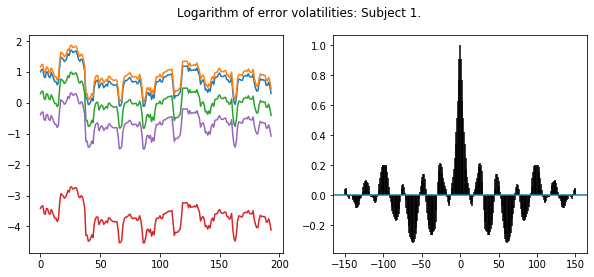

In [31]:
win_data = sliding_window(epsilon_all[0].T, width=15, stepsize=1)
sv = calc_conn(win_data)[:,:,11:-10]
svl = [np.log(np.abs(sv[i,i,:])) for i in range(5)]
ords_sv = np.asarray(find_integration_order(svl))
print(ords_sv.T)

fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(5):
    ax[0].plot(svl[i])
    
ax[1].acorr(svl[0].flatten()-np.mean(svl[0].flatten()), maxlags=150)

plt.suptitle('Logarithm of error volatilities: Subject 1.')

## Analysis of the differenced data

In [17]:
data_diff = np.diff(data, n=1, axis=1)

In [18]:
np.asarray(find_integration_order(data_diff))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [19]:
f_diff, U_diff, epsilon_diff, ncomp_diff = pca_everything(data_diff)

In [20]:
plt.figure()
for r in range(f_diff[2].shape[1]):
    plt.plot(f_diff[2][:,r])

plt.legend([r+1 for r in range(f_diff[2].shape[1])])

In [21]:
# The integration orders are printed.
ords = np.asarray(find_integration_order(f_diff))
ords

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [22]:
# The integration orders are printed.
ords = np.asarray(find_integration_order(epsilon_diff))
ords

array([[1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

First order difference makes everything nicer.